Chap15. 비지도학습

In [2]:
from data_processing import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Chap 1 데이터

data_raw = pd.read_csv('data_ml.csv')
idx_date = data_raw.index[(
    data_raw['date'] > '1999-12-31') & (
    data_raw['date'] < '2019-01-01')].tolist()

#날짜를 받기 위한 인덱스 생성
data_ml = data_raw.iloc[idx_date]
#날짜 인덱스에 따라 데이터셋 필터링
data_ml.iloc[0:6, 0:6]

features = list(data_ml.iloc[:, 3:95].columns)
# 특성의 열 이름 저장 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd",
                  "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

separation_date = "2014-01-15"
idx_train = data_ml.index[(data_ml['date']<separation_date)].tolist()
idx_test = data_ml.index[(data_ml['date']>=separation_date)].tolist()

stock_ids_short = []
stock_days = []

# 각 주식별 데이터 포인트 개수 세기
stock_ids = data_ml['stock_id'].unique()
stock_days = data_ml[['date', 'stock_id']].groupby(
    ['stock_id']).count().reset_index()

# 데이터가 모두 있는 주식을 리스트로 변환
stock_ids_short = stock_days.loc[
    stock_days['date'] == (stock_days['date'].max())]
stock_ids_short = stock_ids_short['stock_id'].unique()
is_stock_ids_short = data_ml['stock_id'].isin(stock_ids_short)
returns = data_ml[is_stock_ids_short].pivot(
    index='date', columns='stock_id', values='R1M_Usd'
)

In [3]:
training_sample = data_ml[data_ml.index.isin(idx_train)]
testing_sample = data_ml[data_ml.index.isin(idx_test)]
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values
y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values

In [4]:
import statsmodels.api as sm

stat = sm.OLS(training_sample['R1M_Usd'],
              sm.add_constant(training_sample[features])).fit()
# 중요 예측 인자만을 보유 / 회귀 변수회귀 변수의 유의성 임계치
reg_thrhld = 3
boo_filter = np.abs(stat.tvalues) >= reg_thrhld

estimate = stat.params[boo_filter]
std_error = stat.bse[boo_filter]
statistic = stat.tvalues[boo_filter]
p_value = stat.pvalues[boo_filter]

significant_regressors = pd.concat([estimate, std_error, statistic, p_value], axis=1)
significant_regressors.columns = ['estimate', 'std.error', 'statistic', 'p.value']
significant_regressors

,estimate,std.error,statistic,p.value
const,0.040715,0.005342,7.622191,2.505071e-14
Ebitda_Margin,0.013243,0.003493,3.791718,1.496529e-04
Ev_Ebitda,0.006782,0.002256,3.005943,2.647917e-03
Fa_Ci,0.007222,0.002347,3.077934,2.084699e-03
Fcf_Bv,0.025101,0.005131,4.891808,9.999185e-07
Fcf_Yld,-0.015997,0.003735,-4.282802,1.846412e-05
Mkt_Cap_12M_Usd,0.226810,0.022014,10.303229,6.912903e-25
Mkt_Cap_6M_Usd,-0.200716,0.043236,-4.642354,3.446830e-06
Mom_5M_Usd,-0.018807,0.004430,-4.245324,2.183775e-05
Mom_Sharp_11M_Usd,0.017743,0.004694,3.779522,1.571758e-04


<Axes: >

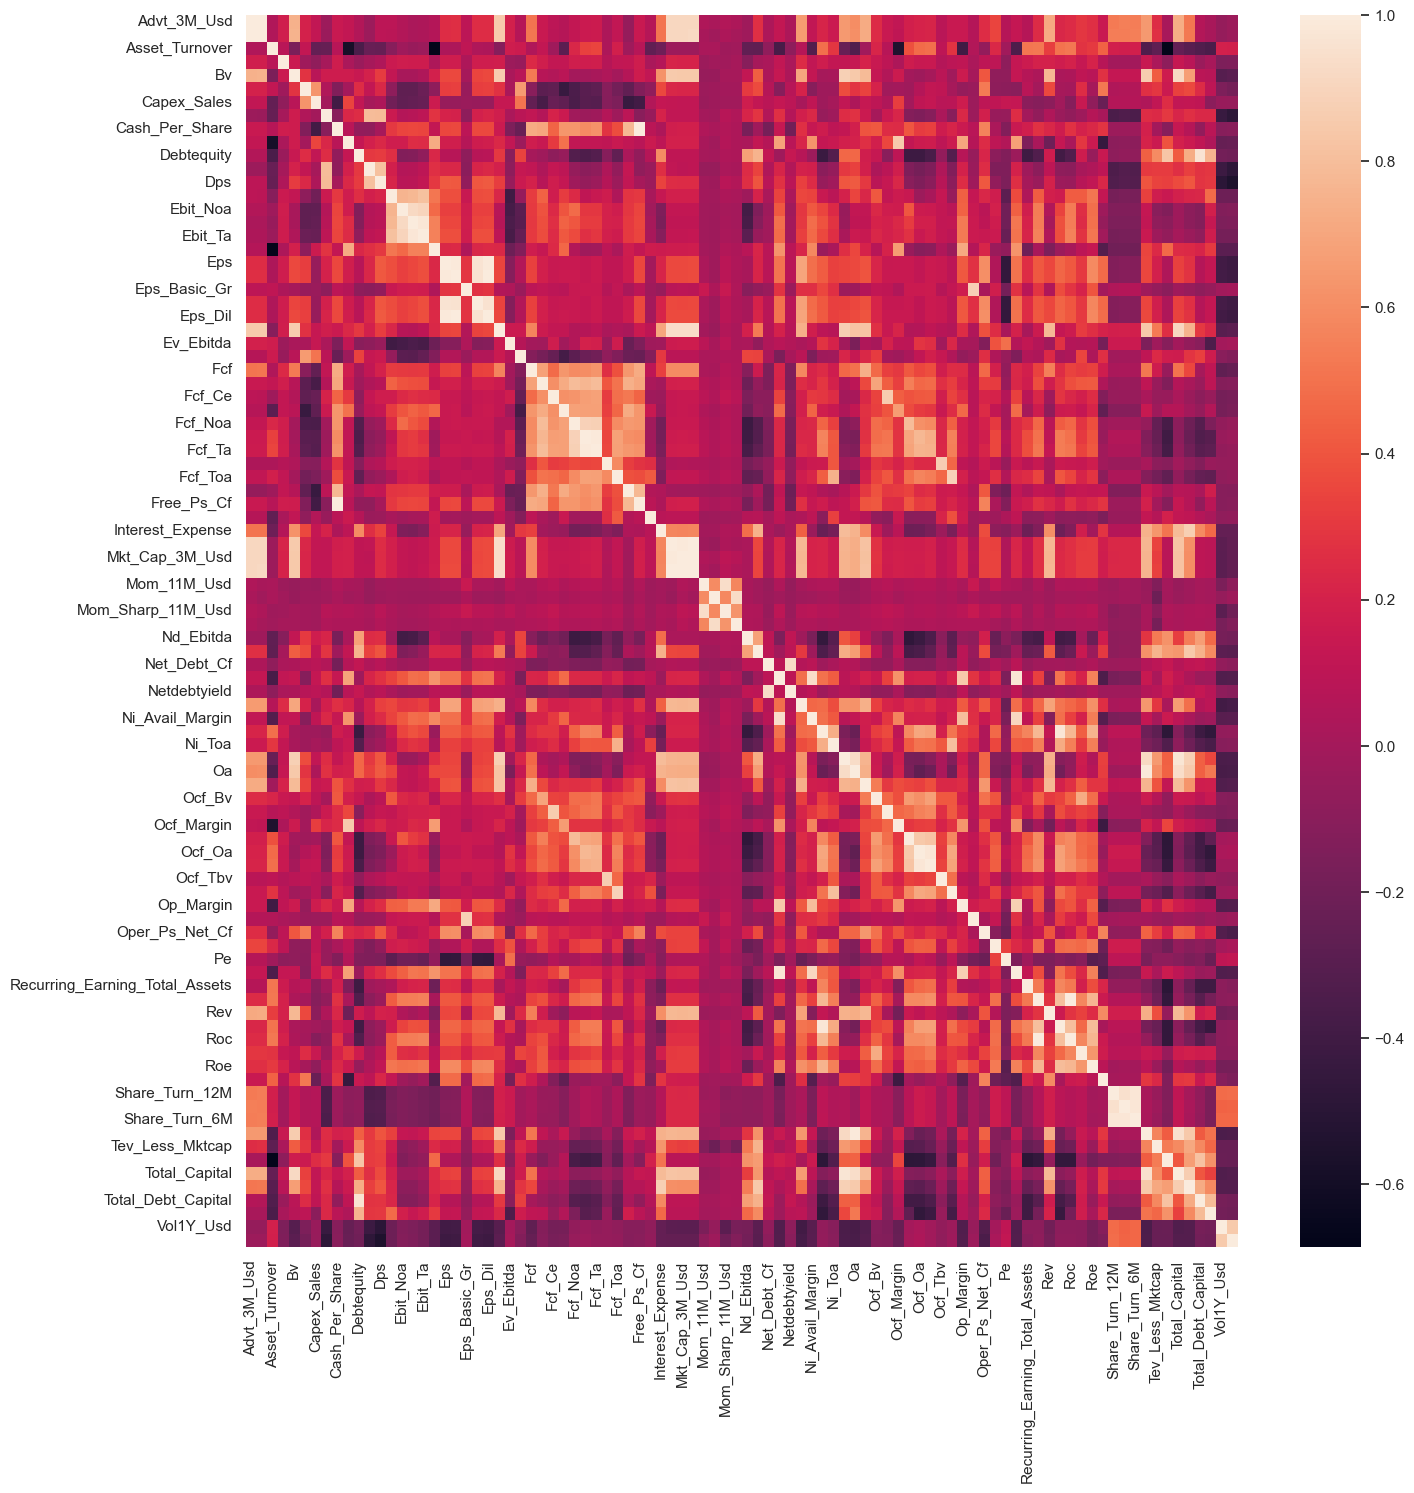

In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,16)})
sns.heatmap(training_sample[features].corr())

In [11]:
# 주성분분석 (PCA) - 예측인자의 개수를 줄이는 법
from sklearn import decomposition

pca = decomposition.PCA(n_components=7)
pca.fit(training_sample[features_short])
print(pca.explained_variance_ratio_)
P = pd.DataFrame(pca.components_, columns=features_short).T
P.columns = ['P' + str(col) for col in P.columns]
P

[0.35718238 0.1940806  0.15561321 0.10434453 0.09601422 0.07017118
 0.02259388]


,P0,P1,P2,P3,P4,P5,P6
Div_Yld,0.271599,-0.579099,-0.045725,0.528956,-0.226626,0.506566,0.032012
Eps,0.420407,-0.150082,0.024767,-0.337373,0.771377,0.301883,0.011965
Mkt_Cap_12M_Usd,0.523868,0.343239,-0.172289,-0.062495,-0.252781,0.002987,0.714319
Mom_11M_Usd,0.047238,0.057714,0.897160,-0.241015,-0.250559,0.258477,0.043179
Ocf,0.532947,0.195890,-0.185039,-0.234371,-0.357596,0.049015,-0.676866
Pb,0.152413,0.580806,0.221048,0.682136,0.308665,0.038675,-0.168799
Vol1Y_Usd,-0.406890,0.381139,-0.282162,-0.155411,-0.061575,0.762588,0.008632


[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [7] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[7]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '7 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (35.7% expl.var)', ylabel='PC2 (19.4% expl.var)'>)

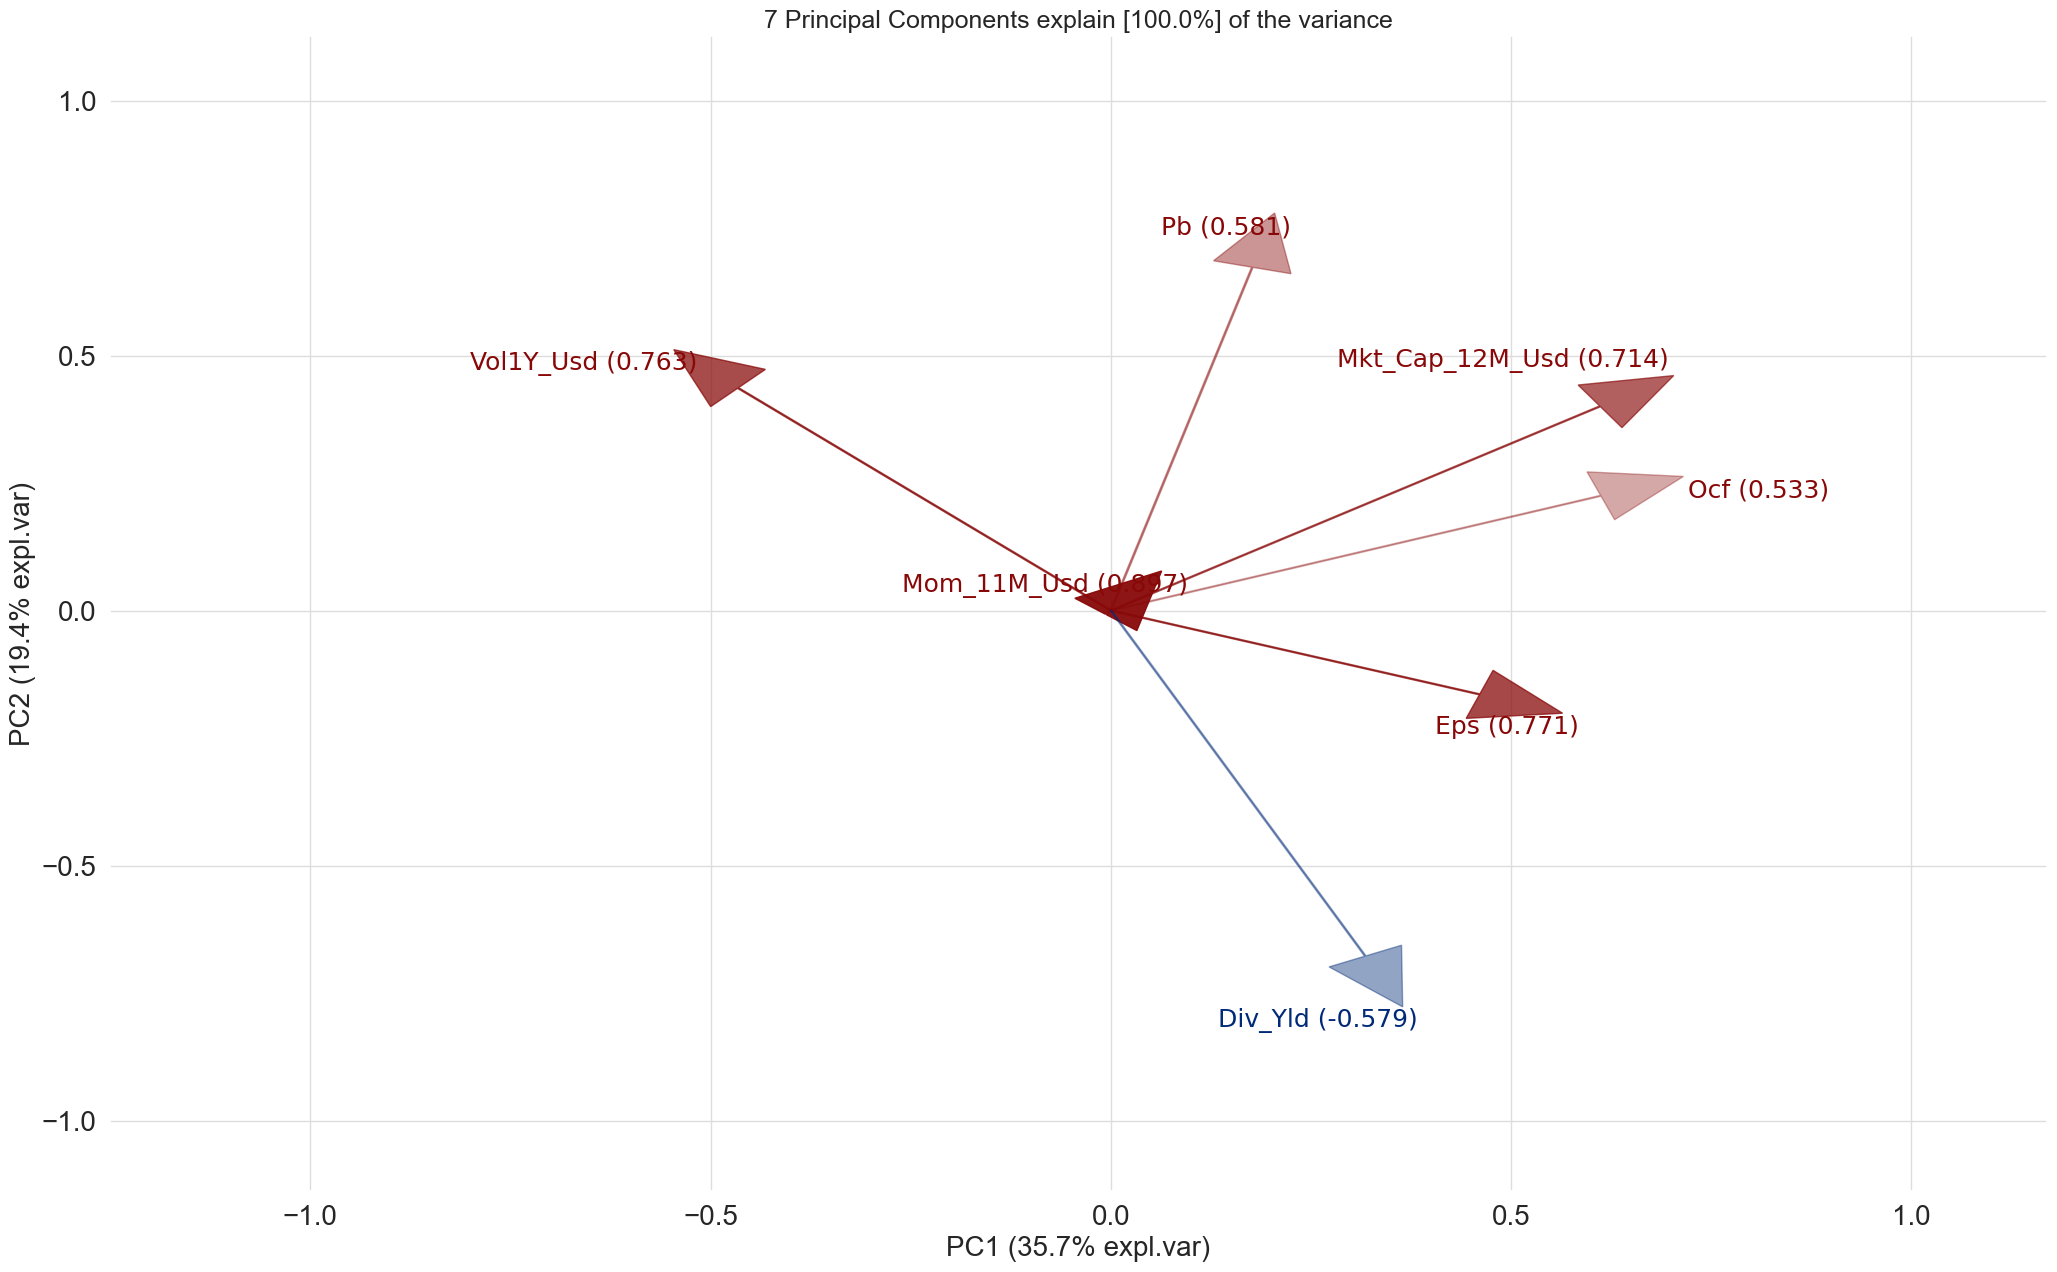

In [13]:
from pca import pca
model = pca(n_components=7)
results = model.fit_transform(training_sample[features_short], col_labels=features_short)
model.biplot(n_feat=7, PC=[0,1], cmap=None, label=None, legend=False)

In [14]:
pd.DataFrame(
    np.matmul(
        training_sample[features_short].values, P.values[:, :4]),
    columns = ['PC1', 'PC2', 'PC3', 'PC4'],    
).head()


,PC1,PC2,PC3,PC4
0,-0.032605,0.553557,-0.032021,0.274928
1,-0.066614,0.621318,-0.053449,0.218684
2,-0.069685,0.650055,0.062423,0.174365
3,-0.075235,0.492199,-0.206870,0.372216
4,-0.115116,0.549612,-0.189423,0.312871


In [21]:
# 오토인코더
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import Input, Dense

input_layer = Input(shape=(7,))
encoder = tf.keras.layers.Dense(units=32, activation="sigmoid")(input_layer)
encoder = tf.keras.layers.Dense(units=4)(encoder)
decoder = tf.keras.layers.Dense(units=32, activation="sigmoid")(encoder)
decoder = tf.keras.layers.Dense(units=7)(decoder)

In [33]:
ae_model = keras.Model(input_layer, decoder)
ae_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)

Epoch 1/100


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 2/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 3/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 4/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 5/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 6/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0091 - val_mean_squared_error: 0.0091
Epoch 7/100
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_l

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'MSE'}, xlabel='Epochs', ylabel='MSE'>],
       dtype=object))

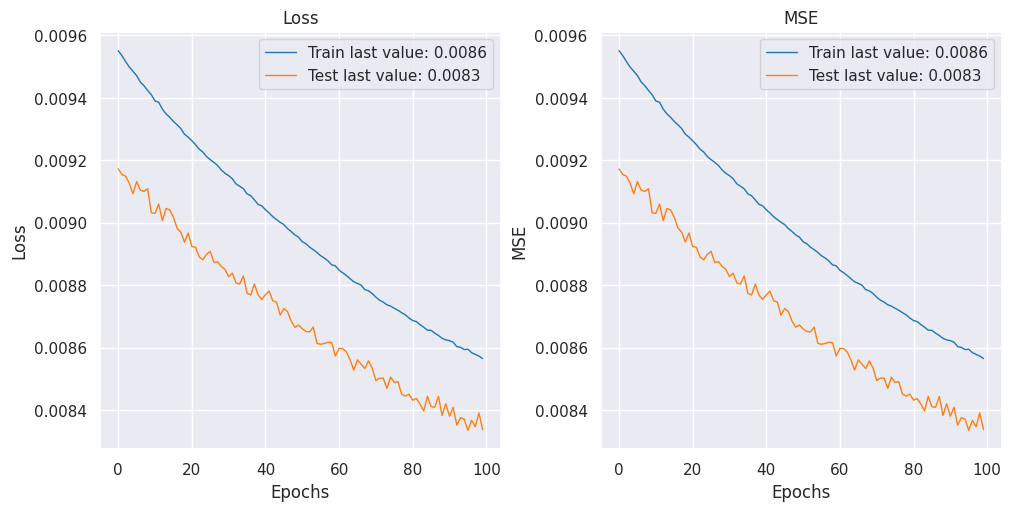

In [39]:
NN_train_features = training_sample[features_short].values
NN_train_labels = training_sample['R1M_Usd'].values
NN_test_features = testing_sample[features_short].values
NN_test_labels = testing_sample['R1M_Usd'].values

from plot_keras_history import show_history, plot_history


history = ae_model.fit(NN_train_features,
                       NN_train_features,
                       epochs=100,
                       batch_size=512,
                       validation_data=(NN_test_features, NN_test_features))
plot_history(history)

In [40]:
ae_weights = ae_model.get_weights()

In [41]:
ae_model.save_weights(filepath="ae_weights.weights.h5", overwrite=True)

In [42]:
#15.3 k-평균을 통한 클러스터링
from sklearn import cluster
k_means = cluster.KMeans(n_clusters=10)
k_means.fit(training_sample[features].T)
clusters = pd.DataFrame([features, k_means.labels_], index=["factor", "cluster"]).T
clusters.loc[clusters['cluster']==4,:]

,factor,cluster
7,Cash_Div_Cf,4
10,Debtequity,4
11,Div_Yld,4
12,Dps,4
46,Nd_Ebitda,4
47,Net_Debt,4
84,Tev_Less_Mktcap,4
85,Tot_Debt_Rev,4
87,Total_Debt,4
88,Total_Debt_Capital,4


In [43]:
# 15.4 최근접 이웃
from sklearn import neighbors as nb
knn_data = data_ml.loc[data_ml['date'] == '2006-12-31',:]
knn_target = knn_data.loc[knn_data['stock_id'] == 13, features]
knn_sample = knn_data.loc[knn_data['stock_id'] != 13, features]
neighbors = nb.NearestNeighbors(n_neighbors=30)
neighbors.fit(knn_sample)

NearestNeighbors(n_neighbors=30)

In [44]:
neigh_dist, neigh_ind = neighbors.kneighbors(knn_target)
print(pd.DataFrame(neigh_ind))

   0   1    2   3    4    5   6    7   8    9   ...   20  21   22   23   24  \
0   9   8  185  99  294  266  21  180  23  191  ...  310  95  165  215  268   

    25   26   27   28  29  
0  194  548  103  539  17  

[1 rows x 30 columns]


In [45]:
knn_labels = knn_data.loc[:, 'R1M_Usd'].values[neigh_ind]
np.sum(knn_labels * np.exp(-neigh_dist)/np.sum(np.exp(-neigh_dist)))


0.03161292361829913

In [46]:
knn_data.loc[knn_data['stock_id'] == 13, 'R1M_Usd']

0    0.089
Name: R1M_Usd, dtype: float64

15.5 코딩 예제  
오토인코더의 인코더 부분을 통해 데이터의 압축버젼을 코딩하라.

In [49]:
input_layer = Input(shape=(7,))
encoder2 = tf.keras.layers.Dense(units=32, activation="sigmoid")(input_layer)
encoder2 = tf.keras.layers.Dense(units=4)(encoder2)
encoder_model = keras.Model(input_layer, encoder2)

encoder_model.compile(
    optimizer="adam",
    loss='mean_squared_error',
    metrics=['mean_squared_error']
)
encoder_model.summary()
encoder_model.load_weights('ae_weights.weights.h5', skip_mismatch=True)
encoder_model.predict_on_batch(training_sample[features_short])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388 (1.52 KB)

 Trainable params: 388 (1.52 KB)

 Non-trainable params: 0 (0.00 B)

c:\ProgramData\miniconda3\envs\tensor\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


array([[-0.7005609 ,  0.64938354, -1.6662511 , -2.5094569 ],
       [-1.1043726 ,  1.6730835 , -2.0605774 , -3.777516  ],
       [-1.3011053 ,  1.8556864 , -2.20044   , -4.001779  ],
       ...,
       [-0.8486053 ,  5.3920918 , -1.1879967 , -5.349061  ],
       [-0.39715186,  4.2226286 , -0.50057006, -3.9598541 ],
       [-5.4262557 ,  1.6889682 ,  1.5797716 , -4.0761223 ]],
      dtype=float32)

Chap16. 강화학습

In [4]:
# Q 러닝 - 시뮬레이션
from statsmodels.tsa.arima_process import ArmaProcess
n_sample = 10**5
rho = 0.8 #자기 회귀 계수
sd = 0.4 #잡음 표준 편차
a = 0.06*(1-rho) #스케일된 수익률 평균

ar1 = np.array([1,-rho]) #ar 매개변수를 위한 템플릿 , rho의 반대 부호
AR_object1 = ArmaProcess(ar1) #AR 객체 생성
simulated_data_AR1 = AR_object1.generate_sample(nsample=n_sample, scale=sd)
returns = a / rho + simulated_data_AR1
action = np.round(np.random.uniform(size=n_sample)*4) / 4 # 임의적 행동
state = np.where(returns < 0 , "neg", "pos")
reward = returns * action

data_RL = pd.DataFrame([returns, action, state, reward]).T
data_RL.columns = ['returns', 'action', 'state', 'reward']
data_RL['new_state'] = data_RL['state'].shift(-1)
data_RL = data_RL.dropna(axis=0).reset_index(drop=True)
data_RL.head()

,returns,action,state,reward,new_state
0,0.314592,0.0,pos,0.0,neg
1,-0.022752,0.0,neg,-0.0,pos
2,0.1942,0.25,pos,0.04855,pos
3,0.392663,1.0,pos,0.392663,pos
4,0.98724,0.75,pos,0.74043,pos


In [5]:
alpha = 0.1 #학습률
gamma = 0.7 #보상에 대한 할인 계수
epsilon = 0.5 #탐험률
def looping_w_counters(obj_array): # 카운터가 있는 루프를 위한 유틸 함수 생성
    _dict = {z: i  for i, z in enumerate(obj_array)}
    return _dict

s = looping_w_counters(data_RL['state'].unique())
a = looping_w_counters(data_RL['action'].unique())
fit_RL = np.zeros(shape=(len(s), len(a)))
r_final = 0
for z, row in data_RL.iterrows():
    act = a[row.action]
    r = row.reward
    s_current = s[row.state]
    s_new = s[row.new_state]
    if np.random.uniform(size=1) < epsilon:
        best_new = a[np.random.choice(list(a.keys()))]
    else:
        best_new = np.argmax(fit_RL[s_new,])
    r_final += r
    fit_RL[s_current, act] += alpha* ( r+gamma*fit_RL[s_new, best_new] - fit_RL[s_current, act])
    
fit_RL = pd.DataFrame(fit_RL, index=s.keys(), columns=a.keys()).sort_index(axis=1)
print(fit_RL)
print(f'Reward (last iteration) : {r_final}')

         0.00      0.25      0.50      0.75      1.00
pos  0.628161  0.667404  0.873188  0.892481  0.815609
neg  0.195540 -0.013866  0.052996 -0.230128 -0.299096
Reward (last iteration) : 842.1730773226639


16.4.2 시장데이터와 Q-러닝

In [8]:
return_3 = pd.Series(data_ml.loc[data_ml['stock_id'] == 3, 'R1M_Usd'].values)
return_4 = pd.Series(data_ml.loc[data_ml['stock_id'] == 4, 'R1M_Usd'].values)
pb_3 = pd.Series(data_ml.loc[data_ml['stock_id'] == 3, 'Pb'].values)
pb_4 = pd.Series(data_ml.loc[data_ml['stock_id'] == 4, 'Pb'].values)
action_3 = pd.Series(np.floor(np.random.uniform(size=len(pb_3))*3) - 1)
action_4 = pd.Series(np.floor(np.random.uniform(size=len(pb_4))*3) - 1)

RL_data = pd.concat([return_3, return_4, pb_3, pb_4, action_3, action_4], axis=1)
RL_data.columns = ['return_3', 'return_4', 'Pb_3', 'Pb_4', 'action_3', 'action_4']

RL_data['action'] = RL_data.action_3.astype(int).apply(str) +" "+RL_data.action_4.astype(int).apply(str)

RL_data['Pb_3'] = np.round(5*RL_data['Pb_3'])
RL_data['Pb_4'] = np.round(5*RL_data['Pb_4'])

RL_data['state'] = RL_data.Pb_3.astype(int).apply(str)+" "+RL_data.Pb_4.astype(int).apply(str)
RL_data['new_state'] = RL_data['state'].shift(-1)

RL_data['reward'] = RL_data.action_3 * RL_data.return_3 + RL_data.action_4 * RL_data.return_4
RL_data = RL_data[['action', 'state', 'reward', 'new_state']].dropna(axis=0).reset_index(drop=True)
RL_data.head()

,action,state,reward,new_state
0,-1 1,1 3,0.116,1 2
1,-1 -1,1 2,-0.082,1 2
2,0 -1,1 2,0.004,2 2
3,-1 0,2 2,0.098,2 2
4,-1 -1,2 2,0.054,2 2


In [9]:
alpha = 0.1
gamma = 0.7
epsilon = 0.1

s = looping_w_counters(data_RL['state'].unique())
a = looping_w_counters(data_RL['action'].unique())
fit_RL2 = np.zeros(shape=(len(s), len(a)))
r_final = 0
for z, row in data_RL.iterrows():
    act = a[row.action]
    r = row.reward
    s_current = s[row.state]
    s_new = s[row.new_state]
    if np.random.uniform(size=1) < epsilon:
        best_new = a[np.random.choice(list(a.keys()))]
    else:
        best_new = np.argmax(fit_RL2[s_new,])
    r_final += r
    fit_RL2[s_current, act] += alpha* ( r+gamma*fit_RL2[s_new, best_new] - fit_RL2[s_current, act])
    
fit_RL2 = pd.DataFrame(fit_RL2, index=s.keys(), columns=a.keys()).sort_index(axis=1)
print(fit_RL2)
print(f'Reward (last iteration) : {r_final}')

         0.00      0.25      0.50      0.75      1.00
pos  0.990001  1.009384  1.169038  1.226621  1.102315
neg  0.487825  0.273316  0.348957  0.047989 -0.072523
Reward (last iteration) : 842.1730773226639


16.6 예제  
1. 수익률 생성 프로세스에 음의 자기 상관관계가 있는 경우 어떤 일이 발생하는지 테스트하라. Q 함수와 정책에 미치는 영향은 무엇인가?

In [10]:
n_sample = 10**5
rho = (-0.8) #자기 회귀 계수
sd = 0.4 #잡음 표준 편차
a = 0.06*(1-rho) #스케일된 수익률 평균

ar1 = np.array([1,-rho]) #ar 매개변수를 위한 템플릿 , rho의 반대 부호
AR_object1 = ArmaProcess(ar1) #AR 객체 생성
simulated_data_AR1 = AR_object1.generate_sample(nsample=n_sample, scale=sd)
returns = a / rho + simulated_data_AR1
action = np.round(np.random.uniform(size=n_sample)*4) / 4 # 임의적 행동
state = np.where(returns < 0 , "neg", "pos")
reward = returns * action

data_RL = pd.DataFrame([returns, action, state, reward]).T
data_RL.columns = ['returns', 'action', 'state', 'reward']
data_RL['new_state'] = data_RL['state'].shift(-1)
data_RL = data_RL.dropna(axis=0).reset_index(drop=True)
data_RL.head()

,returns,action,state,reward,new_state
0,0.014057,0.0,pos,0.0,neg
1,-0.236048,0.75,neg,-0.177036,neg
2,-0.138566,0.0,neg,-0.0,neg
3,-0.633767,1.0,neg,-0.633767,pos
4,0.414033,0.5,pos,0.207016,neg


In [12]:
alpha = 0.1
gamma = 0.7
epsilon = 0.1

s = looping_w_counters(data_RL['state'].unique())
a = looping_w_counters(data_RL['action'].unique())
fit_RL3 = np.zeros(shape=(len(s), len(a)))
r_final = 0
for z, row in data_RL.iterrows():
    act = a[row.action]
    r = row.reward
    s_current = s[row.state]
    s_new = s[row.new_state]
    if np.random.uniform(size=1) < epsilon:
        best_new = a[np.random.choice(list(a.keys()))]
    else:
        best_new = np.argmax(fit_RL3[s_new,])
    r_final += r
    fit_RL3[s_current, act] += alpha* ( r+gamma*fit_RL3[s_new, best_new] - fit_RL3[s_current, act])
    
fit_RL3 = pd.DataFrame(fit_RL3, index=s.keys(), columns=a.keys()).sort_index(axis=1)
print(fit_RL3)
print(f'Reward (last iteration) : {r_final}')

         0.00      0.25      0.50      0.75      1.00
pos  0.324519  0.424383  0.580220  0.751619  0.778019
neg  0.438413  0.301382  0.125524  0.051957 -0.196892
Reward (last iteration) : -6832.604131833959


2. 16.4.2절에서와 동일한 2개의 자산을 유지하면서 각 원본 데이터 포인트에 대해 가능한 모든 작업 조합을 테스트해 RL_data의 크기를 늘린다.  
Q 학습 함수를 다시 실행하고 어떤 일이 발생하는지 확인하라.

In [15]:
n_sample = 10**5
rho = 0.8 #자기 회귀 계수
sd = 0.4 #잡음 표준 편차
a = 0.06*(1-rho) #스케일된 수익률 평균

ar1 = np.array([1,-rho]) #ar 매개변수를 위한 템플릿 , rho의 반대 부호
AR_object1 = ArmaProcess(ar1) #AR 객체 생성
simulated_data_AR1 = AR_object1.generate_sample(nsample=n_sample, scale=sd)
returns = a / rho + simulated_data_AR1
action = np.round(np.random.uniform(size=n_sample)*4) / 4 # 임의적 행동
state = np.where(returns < 0 , "neg", "pos")
reward = returns * action

data_RL = pd.DataFrame([returns, action, state, reward]).T
data_RL.columns = ['returns', 'action', 'state', 'reward']
data_RL['new_state'] = data_RL['state'].shift(-1)
data_RL = data_RL.dropna(axis=0).reset_index(drop=True)
data_RL.head()

,returns,action,state,reward,new_state
0,-0.070408,0.75,neg,-0.052806,pos
1,0.667544,0.25,pos,0.166886,pos
2,0.665524,0.0,pos,0.0,pos
3,0.33006,0.25,pos,0.082515,pos
4,1.071585,0.25,pos,0.267896,pos


In [16]:
return_3 = pd.Series(data_ml.loc[data_ml['stock_id'] == 3, 'R1M_Usd'].values)
return_4 = pd.Series(data_ml.loc[data_ml['stock_id'] == 4, 'R1M_Usd'].values)
pb_3 = pd.Series(data_ml.loc[data_ml['stock_id'] == 3, 'Pb'].values)
pb_4 = pd.Series(data_ml.loc[data_ml['stock_id'] == 4, 'Pb'].values)

# 데이터셋 구축
RL_data = pd.concat([return_3, return_4, pb_3, pb_4], axis=1)
action_3 = pd.Series(np.floor(np.random.uniform(size=len(RL_data))*3) - 1)
action_4 = pd.Series(np.floor(np.random.uniform(size=len(RL_data))*3) - 1)

RL_data = pd.concat([pd.DataFrame(RL_data), pd.DataFrame(action_3), pd.DataFrame(action_4)], axis=1)
RL_data.columns = ['return_3', 'return_4', 'Pb_3', 'Pb_4', 'action_3', 'action_4']

RL_data['action'] = RL_data.action_3.astype(int).apply(str) +" "+RL_data.action_4.astype(int).apply(str)
RL_data['Pb_3'] = np.round(5*RL_data['Pb_3'])
RL_data['Pb_4'] = np.round(5*RL_data['Pb_4'])
RL_data['state'] = RL_data.Pb_3.astype(int).apply(str)+" "+RL_data.Pb_4.astype(int).apply(str)
RL_data['new_state'] = RL_data['state'].shift(-1)

RL_data['reward'] = RL_data.action_3 * RL_data.return_3 + RL_data.action_4 * RL_data.return_4
RL_data = RL_data[['action', 'state', 'reward', 'new_state']].dropna(axis=0).reset_index(drop=True)
RL_data.head()

,action,state,reward,new_state
0,-1 -1,1 3,0.030,1 2
1,0 0,1 2,0.000,1 2
2,0 1,1 2,-0.004,2 2
3,1 1,2 2,-0.062,2 2
4,1 1,2 2,-0.054,2 2


In [17]:
alpha = 0.1
gamma = 0.7
epsilon = 0.1

s = looping_w_counters(data_RL['state'].unique())
a = looping_w_counters(data_RL['action'].unique())
fit_RL4 = np.zeros(shape=(len(s), len(a)))
r_final = 0
for z, row in data_RL.iterrows():
    act = a[row.action]
    r = row.reward
    s_current = s[row.state]
    s_new = s[row.new_state]
    if np.random.uniform(size=1) < epsilon:
        best_new = a[np.random.choice(list(a.keys()))]
    else:
        best_new = np.argmax(fit_RL4[s_new,])
    r_final += r
    fit_RL4[s_current, act] += alpha* ( r+gamma*fit_RL4[s_new, best_new] - fit_RL4[s_current, act])
    
fit_RL4 = pd.DataFrame(fit_RL4, index=s.keys(), columns=a.keys()).sort_index(axis=1)
print(fit_RL4)
print(f'Reward (last iteration) : {r_final}')

         0.00      0.25      0.50      0.75      1.00
neg  0.384009  0.279998  0.087286  0.134587  0.063067
pos  0.776972  0.941115  1.060751  1.338120  1.195739
Reward (last iteration) : 488.7182560184176
